In [1]:
# -------------------------------------------------------------------------------- #
import findspark
findspark.init()
import pyspark
# Pyspark Imports
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext, functions as F
from pyspark.sql.functions import *
from pyspark.sql.functions import corr
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
from pyspark.mllib.linalg import Vectors, Matrices
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.streaming import StreamingContext

# Pymongo
from pymongo import MongoClient

# other libraries
import random
import numpy as np
from urllib.parse import urlparse
# -------------------------------------------------------------------------------- #

<h3>Overflow workflow for the project</h3>
<ol>
  <li>Data pre-processing to create your controlled sandboxed environment —&gt; Big Data Framework.</li>
  <li>Exploratory analyses —&gt; Sandbox, so standard lib.</li>
  <li>Results extension and data modeling on the whole big data source (ensure scalability and/or continuous application) —&gt; Big Data Framework.</li>
</ol>
<strong><p>This notebook is the step two. Data is already put into HDFS which is in Big Data Framework</p></strong>

## Explanatory Analysis


<h3>In this section,I will perform the following tasks</h3>
<ol>
  <li>Create a spark session.</li>
  <li>With Pyspark, we will connect to HDFS, read our data.csv file.</li>
  <li>After the successfull loading of the data into spark df, we will perform analysis.</li>
  <li>Once we're ready with our final format, I'll load the data into mongodb for longterm storage</li>
</ol>

In [2]:
# -------------------------------------------------------------------------------- #
# Start a Spark session
spark = SparkSession.builder.appName("MyApp")\
    .config("spark.mongodb.input.uri", "mongodb://localhost/mydb.myCollection")\
    .config("spark.driver.memory", "8g")\
    .config("spark.mongodb.output.uri", "mongodb://localhost/mydb.myCollection")\
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.3.5') \
    .getOrCreate()

# -------------------------------------------------------------------------------- #

Ivy Default Cache set to: /home/mert/.ivy2/cache
The jars for the packages stored in: /home/mert/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.mongodb.spark#mongo-spark-connector_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9e531b15-5f91-4439-a133-59adc0e94e0c;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.11;2.3.5 in central
	found org.mongodb#mongo-java-driver;3.12.5 in central
:: resolution report :: resolve 301ms :: artifacts dl 10ms
	:: modules in use:
	org.mongodb#mongo-java-driver;3.12.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.11;2.3.5 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------

In [3]:
df_spark = spark.read.format("csv").option("header", "true").load("hdfs://localhost:54310/data")

In [4]:
# -------------------------------------------------------------------------------- #
# Check the active sessions
active_session = SparkSession.builder.getOrCreate()
#active_session.stop()
active_session
# -------------------------------------------------------------------------------- #

In [5]:
# -------------------------------------------------------------------------------- #
spark_frame = spark.read.csv("data/data.csv", inferSchema = True, header = True)
# -------------------------------------------------------------------------------- #

In [6]:
# -------------------------------------------------------------------------------- #
spark_frame.printSchema()
# -------------------------------------------------------------------------------- #

root
 |-- Bankrupt?: integer (nullable = true)
 |--  ROA(C) before interest and depreciation before interest: double (nullable = true)
 |--  ROA(A) before interest and % after tax: double (nullable = true)
 |--  ROA(B) before interest and depreciation after tax: double (nullable = true)
 |--  Operating Gross Margin: double (nullable = true)
 |--  Realized Sales Gross Margin: double (nullable = true)
 |--  Operating Profit Rate: double (nullable = true)
 |--  Pre-tax net Interest Rate: double (nullable = true)
 |--  After-tax net Interest Rate: double (nullable = true)
 |--  Non-industry income and expenditure/revenue: double (nullable = true)
 |--  Continuous interest rate (after tax): double (nullable = true)
 |--  Operating Expense Rate: double (nullable = true)
 |--  Research and development expense rate: double (nullable = true)
 |--  Cash flow rate: double (nullable = true)
 |--  Interest-bearing debt interest rate: double (nullable = true)
 |--  Tax rate (A): double (nullable = t

In [7]:
# -------------------------------------------------------------------------------- #
columns = df_spark.columns
# -------------------------------------------------------------------------------- #

In [8]:
df_spark.show(1)

23/02/23 22:43:52 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


+---------+--------------------------------------------------------+---------------------------------------+--------------------------------------------------+-----------------------+----------------------------+----------------------+--------------------------+----------------------------+--------------------------------------------+-------------------------------------+-----------------------+--------------------------------------+-----------------+------------------------------------+-------------+------------------------+------------------------+------------------------+----------------------------------------+--------------------+---------------------------+------------------------------------+-----------------------------------------+----------------------------------------+-----------------------------+---------------------------------+-------------------------------+----------------------------------+------------------------+----------------------+------------------------------

In [9]:
df_spark.describe('Bankrupt?').show()

[Stage 4:=============================>                             (1 + 1) / 2]

+-------+-------------------+
|summary|          Bankrupt?|
+-------+-------------------+
|  count|               6819|
|   mean|0.03226279513125092|
| stddev|0.17671017660774013|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [10]:
df_spark.describe('Bankrupt?').show()

+-------+-------------------+
|summary|          Bankrupt?|
+-------+-------------------+
|  count|               6819|
|   mean|0.03226279513125092|
| stddev|0.17671017660774013|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [11]:
# Show the schema of the file.
df_spark.printSchema()

root
 |-- Bankrupt?: string (nullable = true)
 |--  ROA(C) before interest and depreciation before interest: string (nullable = true)
 |--  ROA(A) before interest and % after tax: string (nullable = true)
 |--  ROA(B) before interest and depreciation after tax: string (nullable = true)
 |--  Operating Gross Margin: string (nullable = true)
 |--  Realized Sales Gross Margin: string (nullable = true)
 |--  Operating Profit Rate: string (nullable = true)
 |--  Pre-tax net Interest Rate: string (nullable = true)
 |--  After-tax net Interest Rate: string (nullable = true)
 |--  Non-industry income and expenditure/revenue: string (nullable = true)
 |--  Continuous interest rate (after tax): string (nullable = true)
 |--  Operating Expense Rate: string (nullable = true)
 |--  Research and development expense rate: string (nullable = true)
 |--  Cash flow rate: string (nullable = true)
 |--  Interest-bearing debt interest rate: string (nullable = true)
 |--  Tax rate (A): string (nullable = tr

## Feature Selection

In [12]:
# convert to vector column first
df_spark = df_spark.select([col(c).cast("float").alias(c) for c in df_spark.columns])
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_spark.columns, outputCol=vector_col)
df_vector = assembler.transform(df_spark).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
print(type(matrix))

23/02/23 22:43:58 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/02/23 22:43:58 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


<class 'pyspark.sql.dataframe.DataFrame'>


23/02/23 22:44:00 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


In [13]:
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()
len(cor_np)

96

<AxesSubplot:>

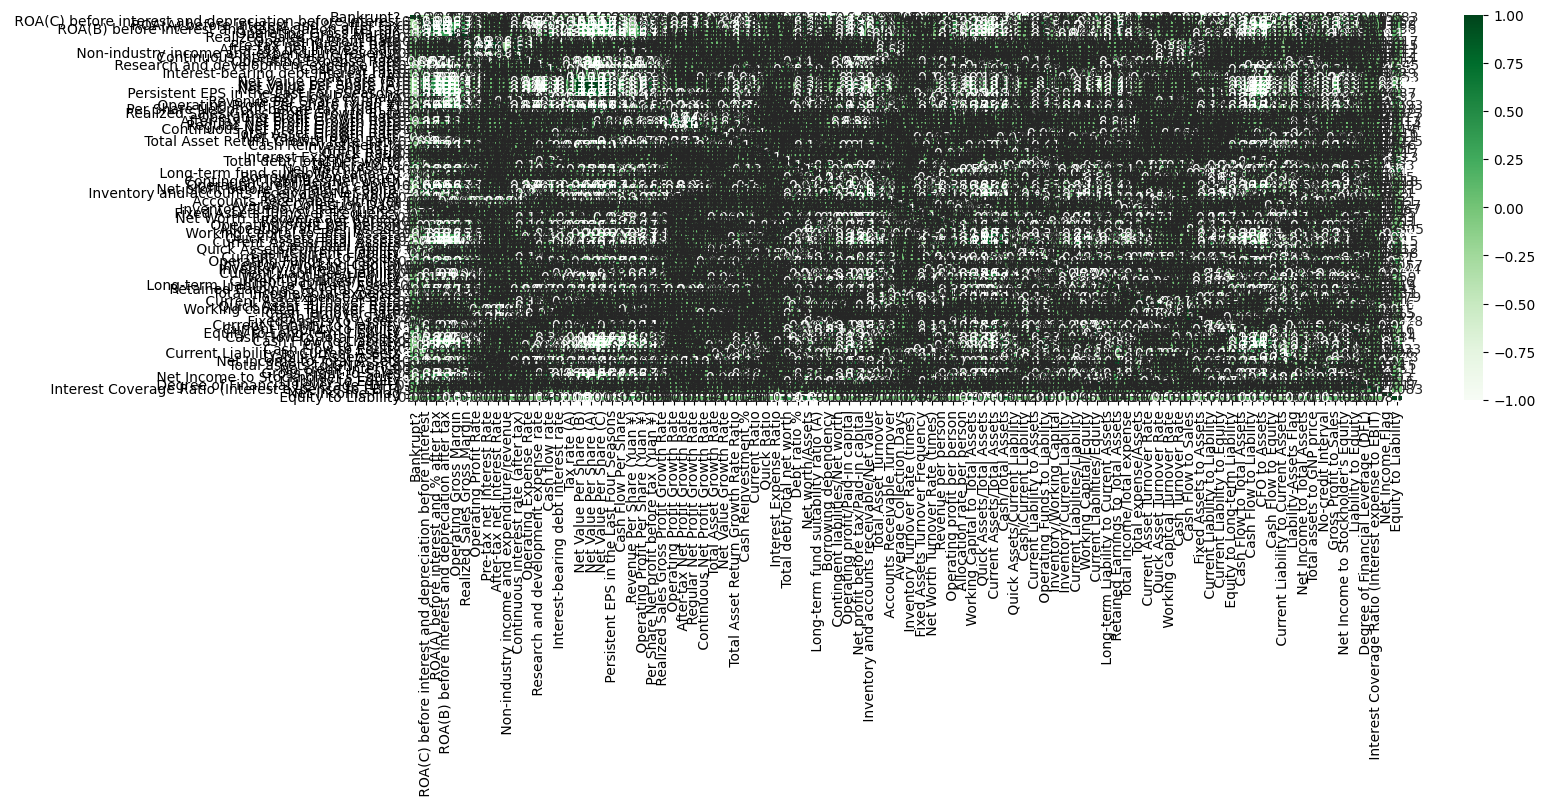

In [14]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))  
sns.heatmap(cor_np, 
            xticklabels=df_spark.columns,
            yticklabels=df_spark.columns,  cmap="Greens", annot=True)

In [15]:
def drop_low_variance(data, k):
    assembler = VectorAssembler(inputCols=data.columns, outputCol="features")
    assembled_data = assembler.transform(data)

    selector = ChiSqSelector(numTopFeatures=k, featuresCol="features",
                             outputCol="selectedFeatures", selectorType="numTopFeatures")
    selector_model = selector.fit(assembled_data)
    result = np.array(data.columns)[selector_model.selectedFeatures]
    
    return result

# Have to change the "Bankrupt?" to "label", otherwise it throws an error.
# Run the following line for once
df_spark = df_spark.withColumnRenamed("Bankrupt?", "label")

selected_data = drop_low_variance(df_spark,25)


In [16]:
selected_data_frame = df_spark.select(selected_data.tolist())

In [17]:
selected_data_frame.printSchema()

root
 |-- label: float (nullable = true)
 |--  ROA(C) before interest and depreciation before interest: float (nullable = true)
 |--  ROA(A) before interest and % after tax: float (nullable = true)
 |--  ROA(B) before interest and depreciation after tax: float (nullable = true)
 |--  Operating Profit Rate: float (nullable = true)
 |--  Pre-tax net Interest Rate: float (nullable = true)
 |--  After-tax net Interest Rate: float (nullable = true)
 |--  Non-industry income and expenditure/revenue: float (nullable = true)
 |--  Continuous interest rate (after tax): float (nullable = true)
 |--  Interest-bearing debt interest rate: float (nullable = true)
 |--  Net Value Per Share (B): float (nullable = true)
 |--  Net Value Per Share (A): float (nullable = true)
 |--  Net Value Per Share (C): float (nullable = true)
 |--  Persistent EPS in the Last Four Seasons: float (nullable = true)
 |--  Operating Profit Per Share (Yuan ¥): float (nullable = true)
 |--  Per Share Net profit before tax (

## Undersampling

In [18]:
class_counts = selected_data_frame.groupBy('label').count().collect()
count_0 = [row['count'] for row in class_counts if row['label'] == 0][0]
count_1 = [row['count'] for row in class_counts if row['label'] == 1][0]

In [19]:
# Compute the under-sampling ratio for the label 0 class
undersampling_ratio = float(count_1) / float(count_0)
# Create a sampling fraction for the label 0 class
sampling_fractions = {0: undersampling_ratio, 1: 1.0}

In [20]:
undersampled_df = selected_data_frame.sampleBy('label', fractions=sampling_fractions, seed=42)

In [21]:
class_counts_undersampled =  undersampled_df.groupBy('label').count().collect()
class_counts_undersampled

[Row(label=1.0, count=220), Row(label=0.0, count=240)]

In [22]:
from pyspark.ml.classification import LinearSVC, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Load the final dataframe into MongoDb

When using the mongo-spark-connector, the data is written to MongoDB in parallel using multiple threads, which suits our needs.

In [23]:
# Connect to the MongoDB server and create the database and collection
mongo_uri = "mongodb://localhost:27017/"
client = MongoClient(mongo_uri)
db = client['mydb']
collection = db['myCollection']

In [24]:
def write_to_mongodb(undersampled_df):
    # Write the undersampled data to MongoDB using the mongo-spark-connector
    undersampled_df.write.format("com.mongodb.spark.sql.DefaultSource") \
        .option("database", "mydb") \
        .option("collection", "myCollection") \
        .mode("overwrite") \
        .save()

    # Print a message indicating that the write was successful
    print("Data has been written to MongoDB")

    # Close the MongoDB connection
    client.close()


In [25]:
write_to_mongodb(undersampled_df)

Data has been written to MongoDB
